In [26]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

In [27]:
#Importing dataFrames
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [28]:
#EDA
#Checking NaN values of each dataset
print(df_train.isnull().sum())
print(' ')
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [29]:
#Deleting features that are not important
df_train = df_train.drop(columns=['PassengerId', 'Cabin', 'Name', 'Ticket'])
df_test_passengerId = df_test['PassengerId']
df_test = df_test.drop(columns=['PassengerId', 'Cabin', 'Name', 'Ticket'])

df_train = df_train.dropna(axis=0, subset=['Embarked'])

In [30]:
#Summary of Data
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [31]:
df_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S


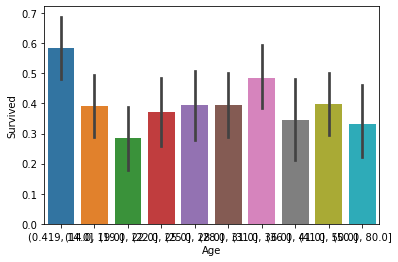

(0.419, 14.0]    77
(14.0, 19.0]     87
(19.0, 22.0]     67
(22.0, 25.0]     70
(25.0, 28.0]     61
(28.0, 31.0]     66
(31.0, 36.0]     91
(36.0, 41.0]     52
(41.0, 50.0]     78
(50.0, 80.0]     63
Name: Age, dtype: int64

In [32]:
#First we will create bins based on deciles for age feature X Survival
#Then we will do the same for Fare feature
df_explore = pd.concat([df_train['Age'], df_train['Fare'], df_train['Survived']], axis =1)
df_explore['Age'] = pd.qcut(df_explore['Age'], 10)

sns.barplot(data=df_explore, x='Age', y='Survived')
plt.show()

#Number of passengers for each category
df_explore['Age'].value_counts(sort=False)

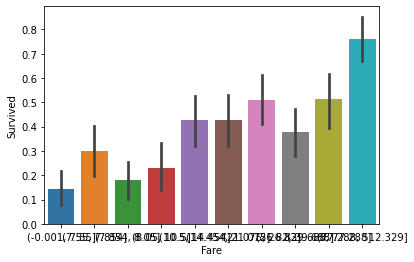

(-0.001, 7.55]        92
(7.55, 7.854]         87
(7.854, 8.05]        106
(8.05, 10.5]          78
(10.5, 14.454]        84
(14.454, 21.075]      87
(21.075, 26.82]       88
(26.82, 39.688]       93
(39.688, 77.288]      86
(77.288, 512.329]     88
Name: Fare, dtype: int64

In [33]:
df_explore['Fare'] = pd.qcut(df_explore['Fare'], 10)

sns.barplot(data=df_explore, x='Fare', y='Survived')
plt.show()

df_explore['Fare'].value_counts(sort=False)

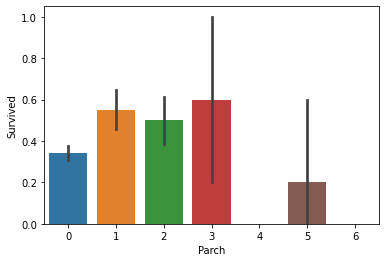

In [34]:
#Visualizing the relationship between parch and survived
sns.barplot(data=df_train, x='Parch', y='Survived')
plt.show()

In [35]:
#Based on the bar plots, we can infer that there should be 4 bins for Age feature
#and 3 bins for Fare feature
#So we will create that
#Then we will estimate the missing values for Age feature

"""
For feature engineering we will do some assumptions here

For Age feature:
We can infer that there is a kinda of a negative correlation for younger passengers (0-19)
Also, older folks are more likely to survive

For Fare feature:
There are some categories that are outliers, but we can see a positive correlation between fare price and survival

We will use 8 bins for Fare and 7 for age

"""

#Creating custom bins
def bining_data(df):
    bins_fare = pd.IntervalIndex.from_tuples([(-0.001, 7.55),
                                              (7.55, 7.854),
                                              (7.854, 10.05),
                                              (10.5, 21.075),
                                              (21.075, 26.82),
                                              (26.82, 39.688),
                                              (39.688, 77.288),
                                              (77.288, 512.329)])
                                               
    bins_age = pd.IntervalIndex.from_tuples([(0.419, 14.0), 
                                              (14.0, 19.0),
                                              (19.0, 22.0),
                                              (22.0, 25.0),
                                              (25.0, 31.0),
                                              (31.0, 36.0),
                                              (36.0, 80)
                                            ])

    #d = dict(zip(bins_fare,['cheap','medium','expensive']))

    df['Fare'] = pd.cut(df['Fare'], bins_fare)
    df['Age'] = pd.cut(df['Age'], bins_age)
    return df

In [36]:
df_train = bining_data(df_train)
df_test = bining_data(df_test)

In [37]:
#Filling missing values in Fare
def fixing_fare_feature(df):
    imp = SimpleImputer(strategy='most_frequent')
    df['Fare'] = df['Fare'].astype("object")
    df['Fare'] = imp.fit_transform(df['Fare'].values.reshape(-1, 1))[:,0]
    df['Fare'] = df['Fare'].astype("category")
    return df

df_train = fixing_fare_feature(df_train)
df_test = fixing_fare_feature(df_test)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.naive_bayes import GaussianNB

In [38]:
#Checking to see if Fare has NaN
print(df_train.isnull().sum())
print(' ')
print(df_test.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64
 
Pclass       0
Sex          0
Age         88
SibSp        0
Parch        0
Fare         0
Embarked     0
dtype: int64


In [39]:
#Creating a new method for filling the missing N.A. values based on a gaussian classifier

def fixingAgeFeature(df_train, df_test):
    # Create the encoder.
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
    encoder.fit(df_train.dropna().drop(['Age', 'Survived'], axis=1))
    X_age_train = encoder.transform(df_train.dropna().drop(['Age', 'Survived'], axis=1))
    y_age_train = df_train.dropna()[['Age']]

    le = LabelEncoder()
    y_age_train = le.fit_transform(y_age_train.values.ravel())

    clf = GaussianNB()
    clf.fit(X_age_train, y_age_train.ravel())
    
    def predictAge(df, clf):
        X_age_predict = df[df['Age'].isna()].drop(['Age'], axis=1)
        X_age_predict = encoder.transform(X_age_predict)
        df_na = df[df['Age'].isna()]
        df = df.dropna()
        arrProb = clf.predict_proba(X_age_predict)

        list = []
        for i in arrProb:
            ageLoop = random.choices(clf.classes_, i, k=1)
            list.append(ageLoop)

        list = le.inverse_transform(list)
        df_na = df_na.assign(Age=list)
        df = pd.concat([df, df_na])
        return df
    
    df_train_survived = df_train['Survived']
    df_train = predictAge(df_train.drop(['Survived'], axis=1), clf)
    df_train = pd.concat([df_train, df_train_survived], axis=1)
    df_test = predictAge(df_test,clf)
    return df_train, df_test

In [40]:
df_train, df_test = fixingAgeFeature(df_train, df_test)

/usr/lib/python3.9/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/lib/python3.9/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [41]:
#Checking to see if there is any NaN left
print(df_train.isnull().sum())
print(' ')
print(df_test.isnull().sum())

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64
 
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [42]:
#Encoding data for classifiers
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_train = df_train.drop(['Survived'], axis=1)
X_train = encoder.fit_transform(X_train)
y_train = df_train['Survived']
X_test = encoder.transform(df_test)

In [43]:
def classificatorScores(listClassificators, scoring,  X_train, y_train):
    for i in listClassificators:
        clf = i[0]
        strName = i[1]
        cv_scores = cross_val_score(clf, X_train, y_train, cv=5,
                            scoring=scoring)
        print('Classificator:' + strName + '; Mean:' + str(cv_scores.mean()))

In [44]:
#Initializing classifiers
svc = svm.SVC()
neigh = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(random_state=0)
adab = AdaBoostClassifier(n_estimators=100, random_state=0)
eclf1 = VotingClassifier(estimators=[
        ('svc', svc), ('neigh', neigh), ('lr', lr)])

In [45]:
listClassificators = [[svc, 'svc'],  [neigh, 'neigh'], [lr, 'lr'], [adab, 'adab'], [eclf1,  'votingClassifier']]

#Checking scores
classificatorScores(listClassificators, 'accuracy', X_train, y_train)

Classificator:svc; Mean:0.8301656827270996
Classificator:neigh; Mean:0.7829048435218688
Classificator:lr; Mean:0.7986796165809686
Classificator:adab; Mean:0.7840411350219006
Classificator:votingClassifier; Mean:0.8301656827270996


In [46]:
#Best score goes to voting classifier
eclf1.fit(X_train, y_train)
prediction = eclf1.predict(X_test)

In [47]:
#Method for creating the archive to submition
def submit_method(PassengerId, Survived):
    my_submission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': Survived})
    # you could use any filename. We choose submission here
    print('Shape of the generated file ' + str(my_submission.shape))
    my_submission.to_csv('submission.csv', index=False)

In [48]:
submit_method(df_test_passengerId, prediction)

#Score

Shape of the generated file (418, 2)
